# Datasets and data loading

The [`torch.utils.data`](https://pytorch.org/docs/stable/data.html) subpackage is an important part of PyTorch for developing neural networks. The `Dataset` class represents a dataset and provides an interface to access the data samples. The `DataLoader` class helps fetch data from the dataset and prepare it for passing to your neural network. 

### Case study: ImageNet data

The ImageNet-1000 image classification task has been a huge driver of progress in deep learning. We will develop a 

In [1]:
import os

# Locate the images
image_dir = '/project/rcde/datasets/imagenet/ILSVRC/Data/CLS-LOC/'
os.listdir(image_dir)

['test', 'train', 'val']

Imagenet has 1000 different classes. Each class has its own sub-folder (test dataset is organized differently): 

In [2]:
for d in os.listdir(image_dir):
    print(d, len(os.listdir(image_dir+d)))

test 100000
train 1000
val 1000


These classes have uninformative directory names:

In [3]:
os.listdir(image_dir+'train')[:5]

['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475']

Most classes have 1300 training images

In [4]:
for cls in os.listdir(image_dir+'train')[::50]:
    print(cls, len(os.listdir(f"{image_dir}train/{cls}/")))

n01440764 1300
n01698640 1300
n01860187 1300
n02077923 1300
n02097474 1300
n02110185 1300
n02165105 1300
n02417914 1300
n02669723 1300
n02860847 1300
n03042490 1300
n03297495 1136
n03532672 1300
n03759954 1300
n03887697 1300
n04033995 1300
n04243546 1300
n04399382 1300
n04562935 1300
n07747607 1300


Most classes have only 50 validation samples

In [5]:
for cls in os.listdir(image_dir+'val')[::50]:
    print(cls, len(os.listdir(f"{image_dir}val/{cls}/")))

n01440764 50
n01698640 50
n01860187 50
n02077923 50
n02097474 50
n02110185 50
n02165105 50
n02417914 50
n02669723 50
n02860847 50
n03042490 50
n03297495 50
n03532672 50
n03759954 50
n03887697 50
n04033995 50
n04243546 50
n04399382 50
n04562935 50
n07747607 50


Let's look at a a few images

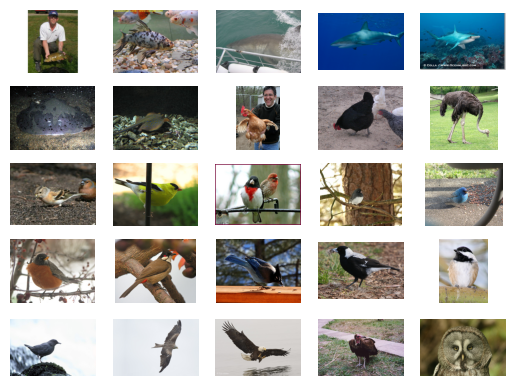

In [6]:
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as img

num_images = 25
sample_images = []
for cls in os.listdir(image_dir+'train')[:num_images]:
    sample_images.append(glob(f"{image_dir}train/{cls}/*.*")[0])
    
fig, ax = plt.subplots(5, 5)
for ix, a in enumerate(ax.flatten()):
    a.imshow(img.imread(sample_images[ix]))
    a.axis('off')

### Map-style dataset
Use this when you have a well-defined set of samples that you will use to train your model. This is the most common case and the natural choice for ImageNet because we have a well-defined set of images that we want to feed to our model. Let's see how to create a map-style dataset class for ImageNet. 

In [41]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms import transforms
from pathlib import Path

# subclass Dataset
class Imagenet(Dataset):
    
    def __init__(self, root_dir: str, split: str, tfms = None):
        """
        The __init__ method is called when creating an instance of the class.
        This is where we put setup code.
        
        Args:
            root_dir: full path to the imagenet CLS-LOC folder containing train and val subfolders
            split: which subfolder to use, either "train" or "val"
            tfms: image transforms 
        
        """
        self.root_dir = root_dir
        self.split = split
        self.tfms = tfms
        
        # make sure split is supported
        assert split in {'train', 'val'}, f"Split must be one of 'train' or 'val', not {split}."
        
        # get a list of all the images
        self.image_paths = list(Path(f"{self.root_dir}/{self.split}").rglob("*.JPEG"))
                                
    def __len__(self):
        """
        Map-style datasets must define the __len__ method. These return the number of 
        samples in the dataset. 
        """
        return len(self.image_paths)
    
    def __getitem__(self, index):
        """
        Map-style datasets must define __getitem__ which takes an index and returns
        a sample. This puts the "map" in "map-style dataset" because it represents
        a mapping from some keys (indices) to the actual data. Map must return 
        a pytorch tensor or numpy array (or a collection thereof).
        """
        
        # read the instance
        img = read_image(self.image_paths[index].as_posix())
        
        # scale to 0 to 1 range
        img = img / 255
        
        if self.tfms:
            img = self.tfms(img)
        
        return img
        
tfms = transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
        
imagenet = Imagenet('/project/rcde/datasets/imagenet/ILSVRC/Data/CLS-LOC/', split='val', tfms=tfms)

print("Number of samples:", len(imagenet))
print("One example:", (a:=imagenet[5]).shape, a.min(), a.max())

Number of samples: 50000
One example: torch.Size([3, 375, 500]) tensor(-2.1179) tensor(2.6400)


### Aside: Mini-Batch Gradient Descent

In the [Regression and Classification notebook](https://clemsonciti.github.io/rcde_workshops/pytorch/02-regression_and_classification.html), we trained the model by computing the loss for the _entire_ dataset multiple times. Our training loop looked something like: 
```python
for i in range(num_epochs):
    # forward pass
    y_hat = model(x)

    # measure the loss
    # this is the mean squared error
    loss = loss_func(y_hat, y)

    # gradient computation
    loss.backward()

    # parameter updates
    optimizer.step()
```

Where `x` and `y` represented the _entire_ input data and target data, respectively. 

---

**Question**: What problems would we run into if we applied this to ImageNet?

---

In most applications of deep learning, we will instead loop over mini-batches (small subsets) of our training data. Our modified training loop will look something like: 
```python
for i in range(num_epochs):
    # Now we have an inner loop over batches of data
    for x_batch, y_batch in batches:
        # forward pass
        y_hat_batch = model(x_batch)

        # measure the loss
        # this is the mean squared error
        loss_batch = loss_func(y_hat_batch, y_batch)

        # gradient computation
        loss_batch.backward()

        # parameter updates
        optimizer.step()
```

Where `batches` is an iterable that returns tuples of the form `(x_batch, y_batch)` representing samples of the full dataset. 

It turns out that 

### Using the dataset with the `DataLoader` class

The `Dataset` class is our interface to the individual samples within our dataset. When training a neural network, we cannot 

In [ ]:
from torch.utils.data import DataLoader

### Iterable-style dataset

### Pytorch built-in datasets

## `Dataloader`